In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns

import random

# Set a random seed to be sure any subsequent random operations will produce the same results
random_seed = 42
random.seed(random_seed)


In [16]:
#final_episodes = pd.read_csv("/home/kabank/workbench/.conda/analysis/kabank-data/final_episodes.csv")
final_episodes = pd.read_csv("/mnt/work/workbench/dipendrp/new-data/ClusterLabel_Full_ICD10_ATC_Dummies_ICD10_ATC_50.csv") #22676

In [17]:
len(final_episodes)

22676

In [18]:
data = final_episodes["tillnextepisode"][final_episodes["tillnextepisode"]>=6934]
len(data)

0

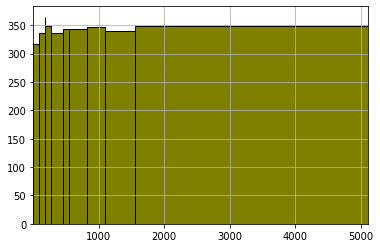

In [19]:
data = final_episodes["tillnextepisode"][final_episodes["tillnextepisode"]<6934]

min_length = final_episodes['tillnextepisode'].min()
max_length = final_episodes['tillnextepisode'].max()
#define function to calculate equal-frequency bins 
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(data, equalObs(data, 10), edgecolor='black', color='olive')
plt.xlim(min_length, max_length)
plt.grid(True)
plt.show()

In [20]:
bins, n

(array([1.000e+00, 8.900e+01, 1.780e+02, 1.840e+02, 2.800e+02, 4.520e+02,
        5.520e+02, 8.160e+02, 1.092e+03, 1.553e+03, 5.109e+03]),
 array([317., 337., 365., 349., 337., 343., 344., 346., 340., 348.]))

In [21]:
# Define conditions
conditions = [
    (0 <= final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] < 89),
    (89 <= final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] < 178),
    (178 <= final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] < 184),
    (184 <= final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] < 280),
    (280 <= final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] < 452),
    (452 <= final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] < 552),
    (552 <= final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] < 816),
    (816 <= final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] < 1092),
    (1092 <= final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] < 1553),
    (1553 <= final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] < 5109),
    (np.isnan(final_episodes['tillnextepisode']))
]

# Define corresponding values
values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0]

# Apply the conditions and values to create the new column 'Cat_TNE'
final_episodes['Cat_TNE'] = np.select(conditions, values, default=None)


In [22]:
final_episodes['Cat_TNE'].value_counts()

Cat_TNE
0     19250
3       365
4       349
10      347
8       346
7       344
6       343
9       340
5       337
2       337
1       317
Name: count, dtype: int64

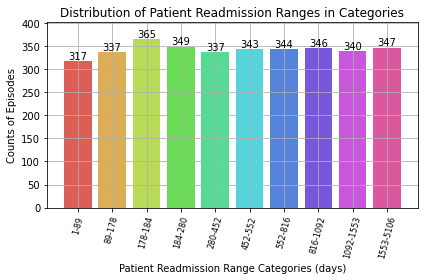

In [23]:
Cat_TNE_0 = len(final_episodes[final_episodes['Cat_TNE']==0]) #'No_more_episode'
Cat_TNE_1 = len(final_episodes[final_episodes['Cat_TNE']==1]) 
Cat_TNE_2 = len(final_episodes[final_episodes['Cat_TNE']==2]) 
Cat_TNE_3 = len(final_episodes[final_episodes['Cat_TNE']==3]) 
Cat_TNE_4 = len(final_episodes[final_episodes['Cat_TNE']==4]) 
Cat_TNE_5 = len(final_episodes[final_episodes['Cat_TNE']==5]) 
Cat_TNE_6 = len(final_episodes[final_episodes['Cat_TNE']==6]) 
Cat_TNE_7 = len(final_episodes[final_episodes['Cat_TNE']==7]) 
Cat_TNE_8 = len(final_episodes[final_episodes['Cat_TNE']==8]) 
Cat_TNE_9 = len(final_episodes[final_episodes['Cat_TNE']==9]) 
Cat_TNE_10 = len(final_episodes[final_episodes['Cat_TNE']==10]) 

# Categories for the x-axis
categories = ['1-89', '89-178', '178-184', '184-280', '280-452', '452-552', '552-816', '816-1092', '1092-1553', '1553-5106']
#categories = ['(0-3)m', '(3-6)m', '(6-9)m', '(9-12)m', '(12-15)m', '(15-21)M', '(21-27)m', '(27-33)m', '(33-39)m', '(39-45)m', '(45-51)m', '(51-57)m', '(57-167)m']
# Counts for each category
counts = [Cat_TNE_1, Cat_TNE_2, Cat_TNE_3, Cat_TNE_4, Cat_TNE_5, Cat_TNE_6, Cat_TNE_7, Cat_TNE_8, Cat_TNE_9, Cat_TNE_10]
colors = sns.color_palette("hls", 10)
# Plot a grouped bar chart
bars = plt.bar(categories, counts, color = colors)
plt.xlabel('Patient Readmission Range Categories (days)')
plt.ylabel('Counts of Episodes')
plt.xticks(rotation=75, fontsize=8)
plt.title('Distribution of Patient Readmission Ranges in Categories')
plt.grid(True)


# Add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(counts) * 1.1)  # 1.1 gives 10% padding at the top
plt.tight_layout()
plt.savefig("/home/kabank/CAMHS_Readmission_Analytics/Paper_figures/Distribution of Patient Readmission Ranges in Categories.png", dpi=300)

plt.show()

In [24]:
# Define conditions
conditions = [
    (0 <= final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] <= 184),
    (184 < final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] <= 816),
    (816 < final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] <= 5106),
    (np.isnan(final_episodes['tillnextepisode']))
]

# Define corresponding values
values = [1, 2, 3, 0]

# Apply the conditions and values to create the new column 'Cat_TNE'
final_episodes['Cat_TNE'] = np.select(conditions, values, default=None)


In [25]:
final_episodes['Cat_TNE'].value_counts()

Cat_TNE
0    19250
2     1378
1     1029
3     1018
Name: count, dtype: int64

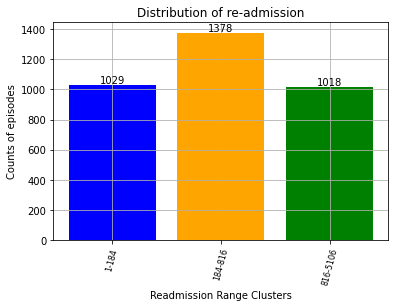

In [26]:
Cat_TNE_0 = len(final_episodes[final_episodes['Cat_TNE']==0]) #'No_more_episode'
Cat_TNE_1 = len(final_episodes[final_episodes['Cat_TNE']==1]) 
Cat_TNE_2 = len(final_episodes[final_episodes['Cat_TNE']==2]) 
Cat_TNE_3 = len(final_episodes[final_episodes['Cat_TNE']==3]) 



# Categories for the x-axis
categories = ['1-184', '184-816', '816-5106']
#categories = ['(0-3)m', '(3-6)m', '(6-9)m', '(9-12)m', '(12-15)m', '(15-21)M', '(21-27)m', '(27-33)m', '(33-39)m', '(39-45)m', '(45-51)m', '(51-57)m', '(57-167)m']
# Counts for each category
counts = [Cat_TNE_1, Cat_TNE_2, Cat_TNE_3]

# Plot a grouped bar chart
bars = plt.bar(categories, counts, color = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
plt.xlabel('Readmission Range Clusters')
plt.ylabel('Counts of episodes')
plt.xticks(rotation=75, fontsize=8)
plt.title('Distribution of re-admission')
plt.grid(True)


# Add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=10)

plt.show()

In [27]:
# Define conditions
conditions = [
    (0 <= final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] <= 365), # 
    (365 < final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] <= 730), # 2 years
    (730 < final_episodes['tillnextepisode']) & (final_episodes['tillnextepisode'] <= 5106), # over 2 years
    (np.isnan(final_episodes['tillnextepisode']))
]

# Define corresponding values
values = [1, 2, 3, 0]

# Apply the conditions and values to create the new column 'Cat_TNE'
final_episodes['Cat_TNE'] = np.select(conditions, values, default=None)

final_episodes['Cat_TNE'].value_counts()

Cat_TNE
0    19250
1     1599
3     1108
2      718
Name: count, dtype: int64